In [1]:
cd ../../

/home/michael/Dropbox/PhD/Python/unified_model


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *

from unified_model.mechanical_system.mechanical_system import MechanicalSystem
from unified_model.mechanical_system.model import ode_decoupled
from unified_model.mechanical_system.damper.damper import Damper
from unified_model.mechanical_system.input_excitation.accelerometer import AccelerometerInput
from unified_model.mechanical_system.input_excitation.footstep import Footstep
from unified_model.mechanical_system.spring.magnetic_spring import MagneticSpring
from unified_model.mechanical_system.magnet_assembly.magnet_assembly import MagnetAssembly


from unified_model.mechanical_system.evaluator import LabeledProcessor, Evaluator
import peakutils

In [6]:
spring = MagneticSpring(fea_data_file = 'unified_model/mechanical_system/spring/data/10x10alt.csv', model='savgol_smoothing', model_type='interp')
magnet_assembly = MagnetAssembly(n_magnet=1,
                                h_magnet=10,
                                h_spacer=0,
                                dia_magnet=10,
                                dia_spacer=10)
damper = Damper(model='constant', model_kwargs={'damping_coefficient' : 0.028})
accelerometer = AccelerometerInput('unified_model/mechanical_system/input_excitation/data/2018-10-04/log_02.csv',
                                  accel_column='z_G',
                                  time_column='time(ms)',
                                  time_unit='ms')

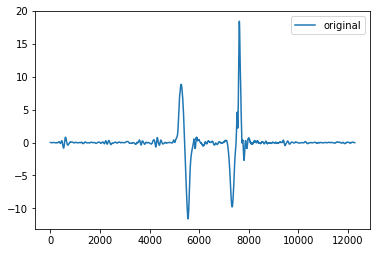

In [10]:
plt.plot(accelerometer.acceleration_df['z_G'], label='original')

In [11]:
system = MechanicalSystem()
system.set_spring(spring)
system.set_damper(damper)
system.set_input(accelerometer)
system.set_magnet_assembly(magnet_assembly)
system.set_model('ode_decoupled', initial_conditions=[0, 0, 0.04, 0])

In [12]:
t = np.arange(1.5, 8.5, 0.01)

In [13]:
system.solve(t)

In [14]:
system.get_output().head()

,time,tube_displacement,tube_velocity,assembly_displacement,assembly_velocity,assembly_relative_displacement,assembly_relative_velocity
0,1.50,0.000000e+00,0.000000,0.040000,0.000000,0.040000,0.000000
1,1.51,-1.246068e-12,-0.001644,0.040050,0.009906,0.040050,0.011550
2,1.52,-1.246068e-12,-0.004427,0.040195,0.018783,0.040195,0.023210
3,1.53,-1.246068e-12,-0.007419,0.040421,0.026168,0.040421,0.033587
4,1.54,-1.246068e-12,-0.009936,0.040712,0.031707,0.040712,0.041642


In [15]:
df_pred = system.get_output().copy()

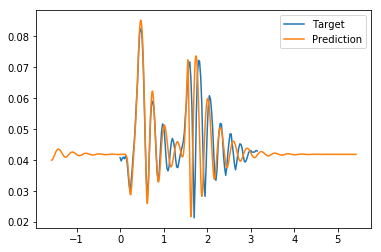

In [16]:
lp = LabeledProcessor(L=125, mf=14, mm=10, seconds_per_frame=0.025)
y_actual, timesteps = lp.fit_transform(pd.read_csv('unified_model/mechanical_system/input_excitation/data/2018-10-04/test-02_transcoded_subsampled_labels_2018-10-12-14:11:27.csv'))
y_predicted = df_pred['assembly_relative_displacement'].values
time_predicted = df_pred['time'].values - df_pred['time'].min()

e = Evaluator(y_target=y_actual, time_target=timesteps)
e.fit(y_predicted=y_predicted, time_predicted=time_predicted)
e.poof()